<a href="https://colab.research.google.com/github/filipeclduarte/forecasting_dynamic_swarm_nn/blob/master/CQSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import cmath
import random
import numpy as np

def simple_func(position):
  """ Simple function that models the problem """
  return position[0]**2 + position[1]**2 + 1

def sphere_func(positions):
  """ Sphere function, global minima is 0
  http://benchmarkfcns.xyz/benchmarkfcns/spherefcn.html"""
  c = np.array(positions)
  x = c**2
  return np.sum(x)

def ackley_func(positions):
  """ Ackley function, global minima is 0"""
  c = np.array(positions)
  firstSum = np.sum(c**2.0)
  secondSum = np.sum(np.cos(2.0*math.pi*c))
  n = float(len(positions))
  return -20.0*math.exp(-0.2*math.sqrt(firstSum/n)) - math.exp(secondSum/n) + 20 + math.e

def alpine_func(positions):
  """ Alpine function, global minima is 0"""
  c = np.array(positions)
  scores = np.sum(abs(c * np.sin(c) + 0.1*c))
  return scores

def schwefel_func(positions):
  """F7 Schwefel's function
  multimodal, asymmetric, separable"""
  c = np.array(positions)
  n = len(c)
  alpha = 418.982887
  fitness = np.sum(c * np.sin(np.sqrt(abs(c))))
  return alpha * n - fitness

def happy_cat_func(positions):
  """ Happy Cat function """
  alpha = 0.5
  c = np.array(positions)
  n = len(c)
  x2 = np.sum(c*c)
  scores = (((x2 - n)**2)**alpha + (0.5*x2 + np.sum(c)))/ (n + 0.5)
  return scores

def brown_func(positions):
  """ Brown function """
  c = np.array(positions)
  n = len(c)
  x = c**2
  scores = 0
  for i in range(n-1):
    scores = scores + x[i]**(x[i+1] + 1) + x[i+1]**(x[i]+1)
  return scores

def exponential_func(positions):
  """ Exponential function """
  c = np.array(positions)
  x2 = c**2
  scores = -np.exp(-0.5 * np.sum(x2))
  return scores


# $PSO$

In [2]:
np.random.seed(0)
def PSO(problem, dimension, var_min, var_max, n_iterations, n_particles, 
        w, c1, c2, show_iter):
  """ PSO algorithm """
  # Initialization
  # np.seterr(over='ignore')
  particle_position_vector = np.random.uniform(var_min,var_max,(
      n_particles, dimension))
  pbest_position = np.copy(particle_position_vector)
  pbest_fitness_value = np.full(shape=n_particles, fill_value=float('inf'))
  gbest_fitness_value = float('inf')
  gbest_position = np.full(shape=dimension, fill_value=0)
  velocity_vector = np.zeros(shape=(n_particles, dimension))
  iteration = 0
  result_list = []
  # Start iterations
  while iteration < n_iterations:
    for p in range(n_particles):
      fitness_candidate = problem(particle_position_vector[p])
      
      # Calculate pbest
      if pbest_fitness_value[p] > fitness_candidate:
        pbest_fitness_value[p] = fitness_candidate
        pbest_position[p] = np.copy(particle_position_vector[p])
    
    # Update velocity of each particle
    for p in range(n_particles):
      new_velocity = (w * velocity_vector[p]) + \
      ((c1 * random.random()) * (pbest_position[p] - particle_position_vector[p])) + \
      ((c2 * random.random()) * (gbest_position - particle_position_vector[p]))
      new_position = new_velocity + particle_position_vector[p]
      # Check if the positions is var_min<x<var_max
      for value in new_position:
        index = list(new_position).index(value)
        new_position[index] = np.max([var_min, value])
        new_position[index] = np.min([var_max, new_position[index]])
      particle_position_vector[p] = new_position
    
    # Calculate gbest
    gbest_candidate = np.min(pbest_fitness_value)
    index_gbest = list(pbest_fitness_value).index(gbest_candidate)
    if gbest_fitness_value > gbest_candidate:
      gbest_fitness_value = gbest_candidate
      gbest_position = np.copy(pbest_position[index_gbest])
    if show_iter:
      print(gbest_fitness_value, " :", gbest_position)
    result_list.append(gbest_fitness_value)
    iteration += 1

  return result_list

In [3]:
np.random.seed(0)
# Problem definition
fitness_values = {"ackley": [ackley_func, -32, 32],
                  "alpine": [alpine_func, 0, 10],
                  "schwefel": [schwefel_func, -500, 500],
                  "happycat": [happy_cat_func, -2, 2],
                  "brown": [brown_func, 0, 10],
                  "exponencial": [exponential_func, -1, 4]}
dimensions = [10, 20, 50]

pso_dim_dic = {}
for dim in dimensions:
  pso_func_dic = {}
  for name, func in fitness_values.items():
    kwargs = {"problem": func[0], "dimension": dim, "var_min": func[1], 
              "var_max": func[2], "n_iterations": 100, "n_particles": 50,
              "w": 0.8, "c1": 1.5, "c2": 1.5, "show_iter": False}
    result = PSO(**kwargs)
    pso_func_dic[name] = result
  pso_dim_dic[dim] = pso_func_dic

# $CPSO-S$ (teste)

In [4]:
# The number of sub swarms is basically the dimension size
n_sub_swarms = 10
n_particles = 2
dimensions = 1
problem = fitness_values["ackley"][0]
var_min = fitness_values["ackley"][1]
var_max = fitness_values["ackley"][2]
w = 0.8
c1 = 1.5
c2 = 1.5

# Initialization
context_vector = np.random.uniform(var_min,var_max,(1, n_particles))[0]
sub_swarm_gbest = np.copy(context_vector)
sub_swarm_pbest = np.copy(context_vector)
multi_swarm_vector = np.random.uniform(var_min,var_max,(n_sub_swarms, n_particles))
velocity_vector = np.zeros(shape=(n_sub_swarms, n_particles))
best_pfitness = problem(context_vector)
best_gfitness = problem(context_vector)
iteration = 0
n_iterations = 500
print("gbest fitness", best_gfitness)
print("gbest inicial:", sub_swarm_gbest)

while iteration < n_iterations:
  # Iterations
  # for sub_swarm in multi_swarm_vector:
  for i_sub_swarm in range(n_sub_swarms):
    # for particle in sub_swarm:
    for i_particle in range(n_particles):
      # Calculate the fitness
      # Vamos calcular o fitness da particula dentro do vetor contexto
      context_copy = np.copy(context_vector)
      particle = multi_swarm_vector[i_sub_swarm][i_particle]
      context_copy[i_particle] = particle
      fitness_candidate = problem(context_copy)
      if fitness_candidate < best_pfitness:
        # Se o fitness da nova particula for melhor ela vira o pbest
        sub_swarm_pbest = np.copy(context_copy)
        best_pfitness = fitness_candidate
      # Feito o pbest devemos atualizar as posicoes das particulas
        new_velocity = (w * velocity_vector[i_sub_swarm][i_particle]) + \
        ((c1 * random.random()) * (sub_swarm_pbest[i_particle] - particle)) + \
        ((c2 * random.random()) * (sub_swarm_gbest[i_particle] - particle))
        new_position = new_velocity + particle
        new_position = np.max([var_min, new_position])
        new_position = np.min([var_max, new_position])
    # Visto todas as particulas do subswarm eu comparo o gbest
    if best_pfitness < best_gfitness:
      sub_swarm_gbest = np.copy(sub_swarm_pbest)
      best_gfitness = best_pfitness
      context_vector = np.copy(sub_swarm_pbest)
  iteration += 1


print("gbest fitness final:", best_gfitness)
print("gbest final:", sub_swarm_gbest)


gbest fitness 20.84202461839423
gbest inicial: [-22.19544416 -29.90005754]
gbest fitness final: 15.197392694637067
gbest final: [-9.99744383 -0.04823159]


# $CPSO-S_K$  (teste)

In [5]:
# The number of sub swarms is basically the dimension size
n_sub_swarms = 4
n_particles = 2
dimensions = 8
problem = fitness_values["ackley"][0]
var_min = fitness_values["ackley"][1]
var_max = fitness_values["ackley"][2]
w = 0.8
c1 = 1.5
c2 = 1.5

# Divide the dimensions per subswarm
num, div = dimensions, n_sub_swarms
dimensions_list = [num // div + (1 if x < num % div else 0)  for x in range (div)]
print(dimensions_list)
print("N dimensions is divisible by K subswarms: ", dimensions % n_sub_swarms == 0)
# Initialization
context_vector = np.empty(n_sub_swarms, dtype=object)
## Create a multiswarm and his velocities
multi_swarm_vector = np.empty((n_sub_swarms,n_particles), dtype=object)
velocity_vector = np.empty((n_sub_swarms,n_particles), dtype=object)
### Change None values for random numbers
for i_subswarm in range(n_sub_swarms):
  context_vector[i_subswarm] = np.random.uniform(
        var_min,var_max,(dimensions_list[i_subswarm]))
  for i_particle in range(n_particles):
    multi_swarm_vector[i_subswarm][i_particle] = np.random.uniform(
        var_min,var_max,(dimensions_list[i_subswarm]))
    velocity_vector[i_subswarm][i_particle] = np.zeros(dimensions_list[i_subswarm])
print("multiswarm", multi_swarm_vector)
## Create fitness for pbest and gbest
gbest = np.copy(multi_swarm_vector[0][0])
pbest = np.copy(multi_swarm_vector[0][0])
sub_swarm_pbest = np.copy(context_vector)
best_pfitness = problem(np.concatenate(context_vector))
best_gfitness = problem(np.concatenate(context_vector))
print("first pbest: ", best_pfitness)
print("first gbest: ", best_gfitness)
iteration = 0
n_iterations = 10

while iteration < n_iterations:
  # Iterations
  # for sub_swarm in multi_swarm_vector:
  for i_sub_swarm in range(n_sub_swarms):
    # for particle in sub_swarm:
    for i_particle in range(n_particles):
      # Calculate the fitness
      # Vamos calcular o fitness da particula dentro do vetor contextos
      context_copy = np.copy(context_vector)
      particle = multi_swarm_vector[i_sub_swarm][i_particle]
      context_copy[i_sub_swarm] = particle
      fitness_candidate = problem(np.concatenate(context_copy))
      if fitness_candidate < best_pfitness:
        # Se o fitness da nova particula for melhor ela vira o pbest
        pbest = np.copy(multi_swarm_vector[i_sub_swarm][i_particle])
        best_pfitness = fitness_candidate
        sub_swarm_pbest = np.copy(context_copy)
      # Feito o pbest devemos atualizar as posicoes das particulas
      new_velocity = (w * velocity_vector[i_sub_swarm][i_particle]) + \
      ((c1 * random.random()) * (pbest - multi_swarm_vector[i_sub_swarm][i_particle])) + \
      ((c2 * random.random()) * (gbest - multi_swarm_vector[i_sub_swarm][i_particle]))
      new_position = new_velocity + multi_swarm_vector[i_sub_swarm][i_particle]
      # Check if the positions is var_min<x<var_max
      for value in new_position:
        index = list(new_position).index(value)
        new_position[index] = np.max([var_min, value])
        new_position[index] = np.min([var_max, new_position[index]])
      multi_swarm_vector[i_sub_swarm][i_particle] = new_position
    # Visto todas as particulas do subswarm eu comparo o gbest
    if best_pfitness < best_gfitness:
      gbest = np.copy(pbest)
      best_gfitness = best_pfitness
      context_vector = np.copy(sub_swarm_pbest)
  iteration += 1

print("Final context vector: ", np.concatenate(context_vector))
print("Gbest: ", gbest)
print(" Fitness of gbest: ", best_gfitness)

[2, 2, 2, 2]
N dimensions is divisible by K subswarms:  True
multiswarm [[array([  1.98701986, -16.78549827]) array([ 5.72168935, -3.46981233])]
 [array([25.565556  , 18.57000237]) array([15.48957259, 26.79235558])]
 [array([-28.28031788,  -9.08106054]) array([ 2.53549419, 27.63473839])]
 [array([ 17.14171276, -23.8992756 ]) array([20.37634017, 19.99729859])]]
first pbest:  21.60554781788713
first gbest:  21.60554781788713
Final context vector:  [ 2.42958289  2.16284924  0.15266238  0.59608398  0.27870723 -0.48521483
  0.93357417  1.45093725]
Gbest:  [0.93357417 1.45093725]
 Fitness of gbest:  6.60965679378679


# $QSO$

In [6]:
dimensions = 4
ex_particles = np.random.uniform(var_min,var_max,dimensions)
gbest = np.random.uniform(var_min,var_max,dimensions)
print(cmath.sqrt(sum((ex_particles - gbest)**2)))
normal = np.random.normal(0, 1, dimensions)
uniform = np.random.uniform(0, 1, dimensions)
select_uniform = random.choice(uniform)
dist = 1
print("ex part: ", ex_particles)
print("gbest: ", gbest)
print("normal:", normal)
print("uniform: ", uniform)
print("random select uniform: ", select_uniform)

(74.35101486164316+0j)
ex part:  [ 26.56841073  31.86314374 -28.17716384 -30.51001633]
gbest:  [ 11.31771412 -23.91332093  16.62383874 -17.19289123]
normal: [ 1.01797544 -0.21325951 -0.62568164  0.65636354]
uniform:  [0.44436828 0.43287244 0.2358742  0.69251282]
random select uniform:  0.4443682764171857


In [7]:
np.random.seed(0)
def QSO(problem, dimension, var_min, var_max, n_iterations, n_particles, 
        w, c1, c2, rcloud, show_iter):
  """ QSO algorithm """
  # Initialization
  # np.seterr(over='ignore')
  particle_position_vector = np.random.uniform(var_min,var_max,(
      n_particles, dimension))
  pbest_position = np.copy(particle_position_vector)
  pbest_fitness_value = np.full(shape=n_particles, fill_value=float('inf'))
  gbest_fitness_value = float('inf')
  gbest_position = np.full(shape=dimension, fill_value=0)
  velocity_vector = np.zeros(shape=(n_particles, dimension))
  iteration = 0
  result_list = []
  # Start iterations
  while iteration < n_iterations:
    for p in range(n_particles):
      fitness_candidate = problem(particle_position_vector[p])
      
      # Calculate pbest
      if pbest_fitness_value[p] > fitness_candidate:
        pbest_fitness_value[p] = fitness_candidate
        pbest_position[p] = np.copy(particle_position_vector[p])    
    # Update velocity of each particle
      dist = cmath.sqrt(sum((particle_position_vector[p] - gbest_position)**2))
      normal = np.random.normal(0, 1, dimension)
      uniform = random.choice(np.random.uniform(0, 1, dimension))
      left_size_form = rcloud * normal
      if dist == 0:
        break
      right_size_form = (uniform ** (1/dimension))/ dist
      new_position = left_size_form * right_size_form
      # print("particle: ", particle_position_vector[p])
      # print("gbest: ", gbest_position)
      # print("subtraction: ", (particle_position_vector[p] - gbest_position))
      # print("pot: ", (particle_position_vector[p] - gbest_position)**2)
      # print("sum: ", sum((particle_position_vector[p] - gbest_position)**2))
      # print("sqrt: ", cmath.sqrt(sum((particle_position_vector[p] - gbest_position)**2)))
      # print("dist", dist)
      # print("normal", normal)
      # print("uniform", uniform)
      # print("left_size_form", left_size_form)
      # print("right_size_form", right_size_form)
      # print("new_position: ", new_position)
      # print("\n")~
      # Check if the positions is var_min<x<var_max
      for value in new_position:
        index = list(new_position).index(value)
        new_position[index] = np.max([var_min, value])
        new_position[index] = np.min([var_max, new_position[index]])
      particle_position_vector[p] = new_position
    
    # Calculate gbest
    gbest_candidate = np.min(pbest_fitness_value)
    index_gbest = list(pbest_fitness_value).index(gbest_candidate)
    if gbest_fitness_value > gbest_candidate:
      gbest_fitness_value = gbest_candidate
      gbest_position = np.copy(pbest_position[index_gbest])
    if show_iter:
      print(gbest_fitness_value, " :", gbest_position)
    result_list.append(gbest_fitness_value)
    iteration += 1

  return result_list

In [8]:
# np.random.seed(0)
# Problem definition
fitness_values = {"ackley": [ackley_func, -32, 32],
                  "alpine": [alpine_func, 0, 10],
                  "schwefel": [schwefel_func, -500, 500],
                  "happycat": [happy_cat_func, -2, 2],
                  "brown": [brown_func, 0, 10],
                  "exponencial": [exponential_func, -1, 4]}
dimensions = [10, 20, 50]

qso_dim_dic = {}
for dim in dimensions:
  qso_func_dic = {}
  for name, func in fitness_values.items():
    kwargs = {"problem": func[0], "dimension": dim, "var_min": func[1], 
              "var_max": func[2], "n_iterations": 100, "n_particles": 50,
              "w": 0.8, "c1": 1.5, "c2": 1.5, "rcloud": 0.2, "show_iter": False}
    result = QSO(**kwargs)
    qso_func_dic[name] = result
  qso_dim_dic[dim] = pso_func_dic

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: ComplexWarning: Casting complex values to real discards the imaginary part


# $CPSO-S_K$

In [9]:
np.random.seed(0)
def CPSO_SK(problem, dimensions, var_min, var_max, n_iterations, n_sub_swarms,
         n_particles, w, c1, c2, show_iter):
  """ CPSO_SK algorithm """
  # Initialization
  # np.seterr(over='ignore')
  # Divide the dimensions per subswarm
  num, div = dimensions, n_sub_swarms
  dimensions_list = [num // div + (1 if x < num % div else 0)  for x in range (div)]
  if not dimensions % n_sub_swarms == 0:
    print("We can't continue, the number of dimensions isn't divisible by the number of subswarms")
    return False
  # Initialization
  context_vector = np.empty(n_sub_swarms, dtype=object)
  ## Create a multiswarm and his velocities
  multi_swarm_vector = np.empty((n_sub_swarms,n_particles), dtype=object)
  velocity_vector = np.empty((n_sub_swarms,n_particles), dtype=object)
  ### Change None values for random numbers
  for i_subswarm in range(n_sub_swarms):
    context_vector[i_subswarm] = np.random.uniform(
          var_min,var_max,(dimensions_list[i_subswarm]))
    for i_particle in range(n_particles):
      multi_swarm_vector[i_subswarm][i_particle] = np.random.uniform(
          var_min,var_max,(dimensions_list[i_subswarm]))
      velocity_vector[i_subswarm][i_particle] = np.zeros(dimensions_list[i_subswarm])
  ## Create fitness for pbest and gbest
  gbest = np.copy(multi_swarm_vector[0][0])
  pbest = np.copy(multi_swarm_vector[0][0])
  sub_swarm_pbest = np.copy(context_vector)
  best_pfitness = problem(np.concatenate(context_vector))
  best_gfitness = problem(np.concatenate(context_vector))
  iteration = 0
  result_list = []

  while iteration < n_iterations:
    # Iterations
    # for sub_swarm in multi_swarm_vector:
    for i_sub_swarm in range(n_sub_swarms):
      # for particle in sub_swarm:
      for i_particle in range(n_particles):
        # Calculate the fitness
        # Vamos calcular o fitness da particula dentro do vetor contextos
        context_copy = np.copy(context_vector)
        particle = multi_swarm_vector[i_sub_swarm][i_particle]
        context_copy[i_sub_swarm] = particle
        fitness_candidate = problem(np.concatenate(context_copy))
        if fitness_candidate < best_pfitness:
          # Se o fitness da nova particula for melhor ela vira o pbest
          pbest = np.copy(multi_swarm_vector[i_sub_swarm][i_particle])
          best_pfitness = fitness_candidate
          sub_swarm_pbest = np.copy(context_copy)
        # Feito o pbest devemos atualizar as posicoes das particulas
        new_velocity = (w * velocity_vector[i_sub_swarm][i_particle]) + \
        ((c1 * random.random()) * (pbest - multi_swarm_vector[i_sub_swarm][i_particle])) + \
        ((c2 * random.random()) * (gbest - multi_swarm_vector[i_sub_swarm][i_particle]))
        new_position = new_velocity + multi_swarm_vector[i_sub_swarm][i_particle]
        # Check if the positions is var_min<x<var_max
        for value in new_position:
          index = list(new_position).index(value)
          new_position[index] = np.max([var_min, value])
          new_position[index] = np.min([var_max, new_position[index]])
        multi_swarm_vector[i_sub_swarm][i_particle] = new_position
      # Visto todas as particulas do subswarm eu comparo o gbest
      if best_pfitness < best_gfitness:
        gbest = np.copy(pbest)
        best_gfitness = best_pfitness
        context_vector = np.copy(sub_swarm_pbest)
    result_list.append(best_gfitness)
    iteration += 1

  return result_list

In [11]:
np.random.seed(0)
# Problem definition
fitness_values = {"ackley": [ackley_func, -32, 32],
                  "alpine": [alpine_func, 0, 10],
                  "schwefel": [schwefel_func, -500, 500],
                  "happycat": [happy_cat_func, -2, 2],
                  "brown": [brown_func, 0, 10],
                  "exponencial": [exponential_func, -1, 4]}
dimensions = [10, 20, 50]

cpsosk_dim_dic = {}
for dim in dimensions:
  cpsosk_func_dic = {}
  for name, func in fitness_values.items():
    kwargs = {"problem": func[0], "dimensions": dim, "var_min": func[1], 
              "var_max": func[2], "n_iterations": 100, "n_sub_swarms": 5, 
              "n_particles": 50, "w": 0.8, "c1": 1.5, "c2": 1.5,
              "show_iter": False}
    result = CPSO_SK(**kwargs)
    cpsosk_func_dic[name] = result
  cpsosk_dim_dic[dim] = cpsosk_func_dic

# $CQSO$

In [12]:
np.random.seed(0)
def CQSO(problem, dimensions, var_min, var_max, n_iterations, n_sub_swarms,
         n_particles, w, c1, c2, neutral_p, rcloud, show_iter):
  """ CQSO algorithm """
  # Initialization
  # np.seterr(over='ignore')
  # Divide the dimensions per subswarm
  num, div = dimensions, n_sub_swarms
  dimensions_list = [num // div + (1 if x < num % div else 0)  for x in range (div)]
  if not dimensions % n_sub_swarms == 0:
    print("We can't continue, the number of dimensions isn't divisible by the number of subswarms")
    return False
  # Initialization
  context_vector = np.empty(n_sub_swarms, dtype=object)
  ## Create a multiswarm and his velocities
  multi_swarm_vector = np.empty((n_sub_swarms,n_particles), dtype=object)
  velocity_vector = np.empty((n_sub_swarms,n_particles), dtype=object)
  ### Change None values for random numbers
  for i_subswarm in range(n_sub_swarms):
    context_vector[i_subswarm] = np.random.uniform(
          var_min,var_max,(dimensions_list[i_subswarm]))
    for i_particle in range(n_particles):
      multi_swarm_vector[i_subswarm][i_particle] = np.random.uniform(
          var_min,var_max,(dimensions_list[i_subswarm]))
      velocity_vector[i_subswarm][i_particle] = np.zeros(dimensions_list[i_subswarm])
  ## Create fitness for pbest and gbest
  gbest = np.copy(multi_swarm_vector[0][0])
  pbest = np.copy(multi_swarm_vector[0][0])
  sub_swarm_pbest = np.copy(context_vector)
  best_pfitness = problem(np.concatenate(context_vector))
  best_gfitness = problem(np.concatenate(context_vector))
  iteration = 0
  result_list = []

  while iteration < n_iterations:
    # Iterations
    # for sub_swarm in multi_swarm_vector:
    for i_sub_swarm in range(n_sub_swarms):
      # for particle in sub_swarm:
      for i_particle in range(n_particles):
        # Calculate the fitness
        # Vamos calcular o fitness da particula dentro do vetor contextos
        context_copy = np.copy(context_vector)
        particle = multi_swarm_vector[i_sub_swarm][i_particle]
        context_copy[i_sub_swarm] = particle
        fitness_candidate = problem(np.concatenate(context_copy))
        if fitness_candidate < best_pfitness:
          # Se o fitness da nova particula for melhor ela vira o pbest
          pbest = np.copy(multi_swarm_vector[i_sub_swarm][i_particle])
          best_pfitness = fitness_candidate
          sub_swarm_pbest = np.copy(context_copy)
        # Feito o pbest devemos atualizar as posicoes das particulas
        if i_particle <= (neutral_p - 1):
          # Atualiza como PSO vanilla
          new_velocity = (w * velocity_vector[i_sub_swarm][i_particle]) + \
          ((c1 * random.random()) * (pbest - multi_swarm_vector[i_sub_swarm][i_particle])) + \
          ((c2 * random.random()) * (gbest - multi_swarm_vector[i_sub_swarm][i_particle]))
          new_position = new_velocity + multi_swarm_vector[i_sub_swarm][i_particle]
        else:
          # Atualiza como QSO
          dist = cmath.sqrt(sum((multi_swarm_vector[i_sub_swarm][i_particle] - gbest)**2))
          normal = np.random.normal(0, 1, dimensions_list[i_subswarm])
          uniform = random.choice(np.random.uniform(0, 1, dimensions_list[i_subswarm]))
          left_size_form = rcloud * normal
          if dist == 0:
            break
          right_size_form = (uniform ** (1/dimensions_list[i_subswarm]))/ dist
          new_position = left_size_form * right_size_form
        # Check if the positions is var_min<x<var_max
        for value in new_position:
          index = list(new_position).index(value)
          new_position[index] = np.max([var_min, value])
          new_position[index] = np.min([var_max, new_position[index]])
        multi_swarm_vector[i_sub_swarm][i_particle] = new_position
      # Visto todas as particulas do subswarm eu comparo o gbest
      if best_pfitness < best_gfitness:
        gbest = np.copy(pbest)
        best_gfitness = best_pfitness
        context_vector = np.copy(sub_swarm_pbest)
    result_list.append(best_gfitness)
    iteration += 1

  return result_list

In [13]:
np.random.seed(0)
# Problem definition
fitness_values = {"ackley": [ackley_func, -32, 32],
                  "alpine": [alpine_func, 0, 10],
                  "schwefel": [schwefel_func, -500, 500],
                  "happycat": [happy_cat_func, -2, 2],
                  "brown": [brown_func, 0, 10],
                  "exponencial": [exponential_func, -1, 4]}
dimensions = [10, 20, 50]

cqso_dim_dic = {}
for dim in dimensions:
  cqso_func_dic = {}
  for name, func in fitness_values.items():
    kwargs = {"problem": func[0], "dimensions": dim, "var_min": func[1], 
              "var_max": func[2], "n_iterations": 100, "n_sub_swarms": 5, 
              "n_particles": 50, "w": 0.8, "c1": 1.5, "c2": 1.5, "neutral_p": 25,
              "rcloud": 0.2, "show_iter": False}
    result = CQSO(**kwargs)
    cqso_func_dic[name] = result
  cqso_dim_dic[dim] = cqso_func_dic

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


# Gráficos

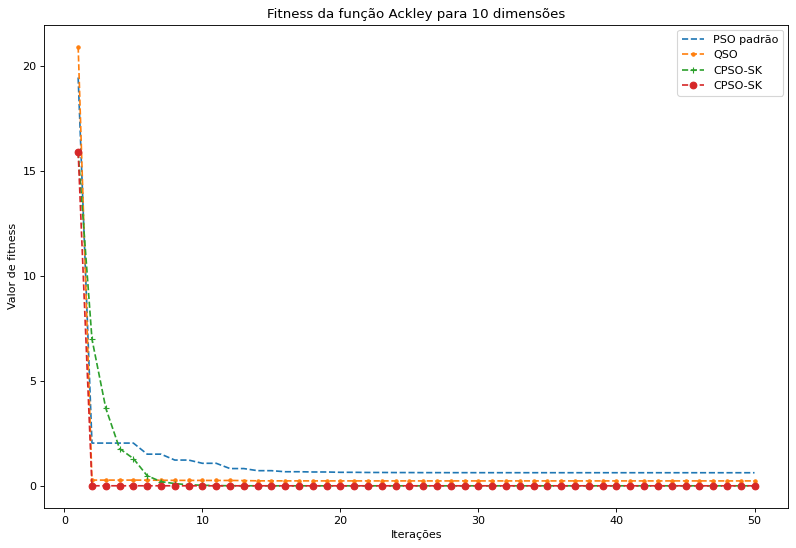

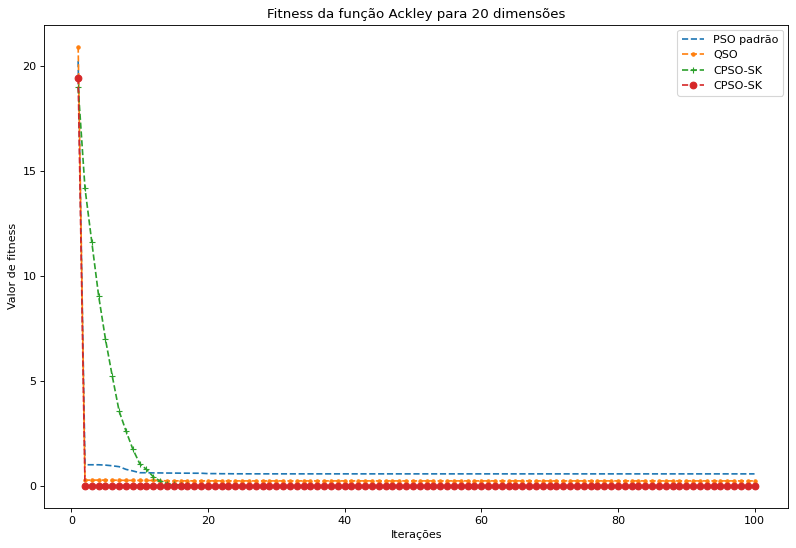

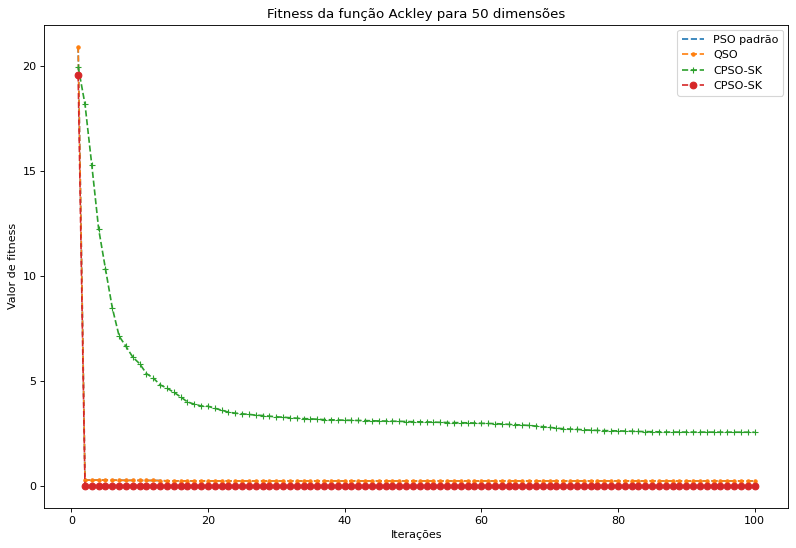

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

def run_plot(pso_dim_dic, qso_dim_dic, cpsosk_dim_dic, cqso_dim_dic, dim, func, size):
  """ Make the fitness plot for each iteration """
  iterations = list(range(1,101))[:size]
  pso_results = pso_dim_dic[dim][func][:size]
  qso_results = qso_dim_dic[dim][func][:size]
  cpsosk_results = cpsosk_dim_dic[dim][func][:size]
  cqso_results = cqso_dim_dic[dim][func][:size]

  plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
  plt.plot(iterations, pso_results, "--", label="PSO padrão")
  plt.plot(iterations, qso_results, ".--", label="QSO")
  plt.plot(iterations, cpsosk_results, "+--", label="CPSO-SK")
  plt.plot(iterations, cqso_results, "o--", label="CPSO-SK")
  plt.xlabel("Iterações")
  plt.ylabel("Valor de fitness")
  plt.title("Fitness da função %s para %s dimensões" % (func.title(), dim))
  plt.legend()
  plt.show()

run_plot(pso_dim_dic, qso_dim_dic, cpsosk_dim_dic, cqso_dim_dic, 10, "ackley", 50)
run_plot(pso_dim_dic, qso_dim_dic, cpsosk_dim_dic, cqso_dim_dic, 20, "ackley", 100)
run_plot(pso_dim_dic, qso_dim_dic, cpsosk_dim_dic, cqso_dim_dic, 50, "ackley", 100)


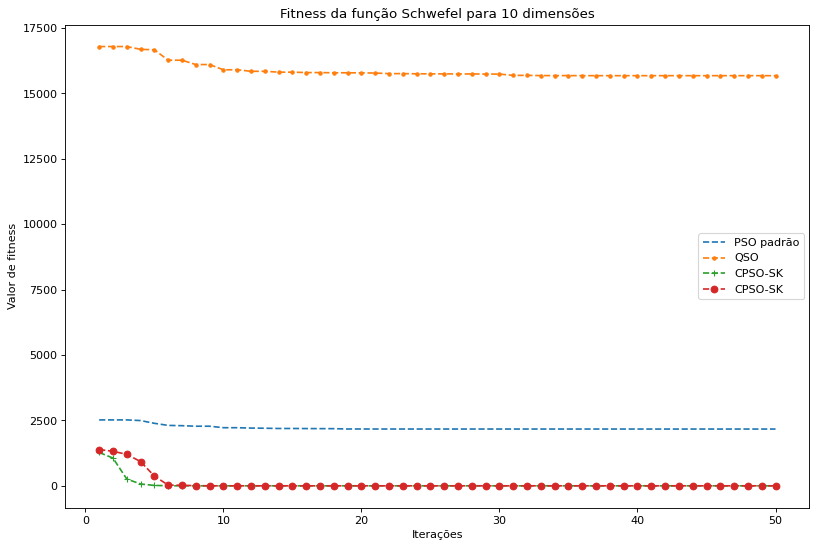

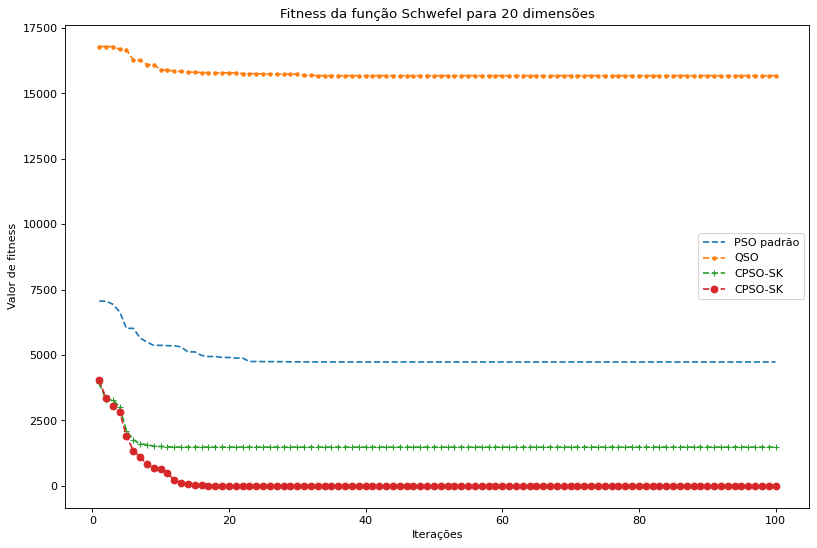

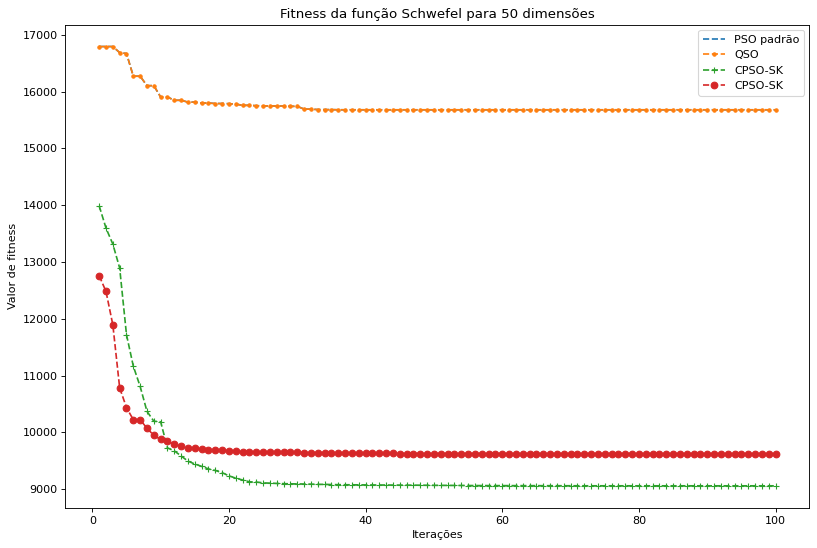

In [17]:
# schwefel
run_plot(pso_dim_dic, qso_dim_dic, cpsosk_dim_dic, cqso_dim_dic, 10, "schwefel", 50)
run_plot(pso_dim_dic, qso_dim_dic, cpsosk_dim_dic, cqso_dim_dic, 20, "schwefel", 100)
run_plot(pso_dim_dic, qso_dim_dic, cpsosk_dim_dic, cqso_dim_dic, 50, "schwefel", 100)